Initial shape: (119390, 32)
Cleaned shape: (86864, 32)


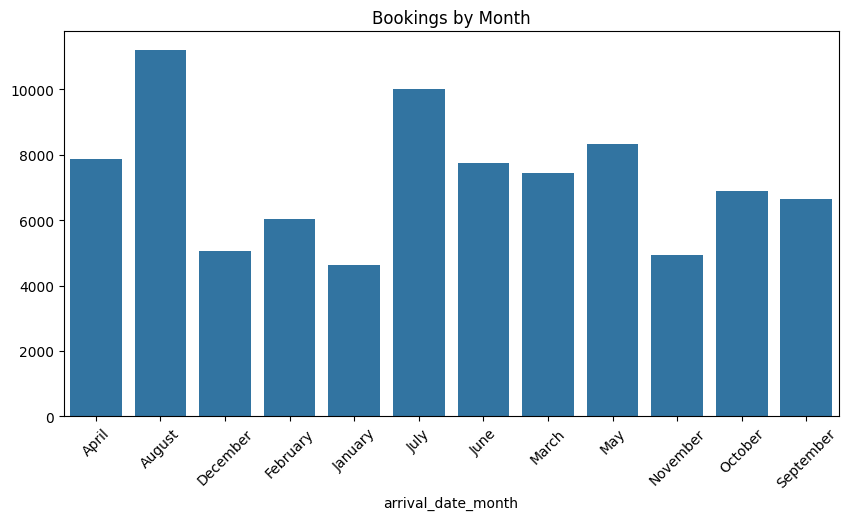

Cancellation Rate:
 is_canceled
0    72.438525
1    27.561475
Name: proportion, dtype: float64


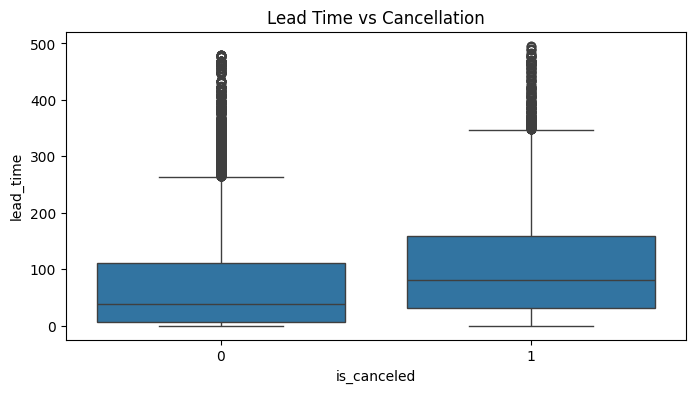

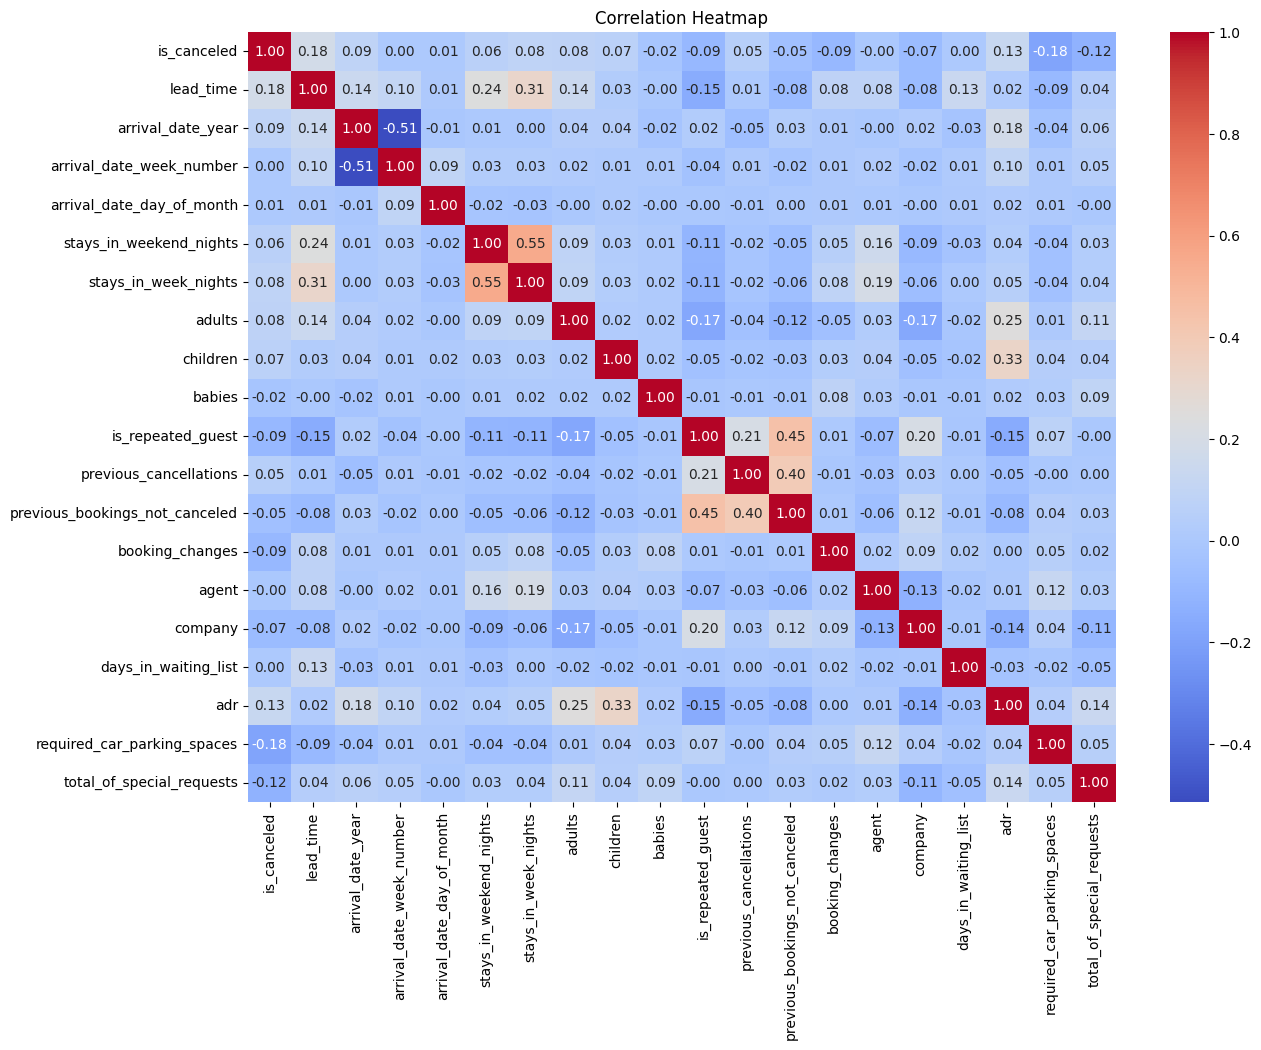


Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.85      0.82     12676
           1       0.50      0.42      0.45      4697

    accuracy                           0.73     17373
   macro avg       0.65      0.63      0.64     17373
weighted avg       0.72      0.73      0.72     17373


Confusion Matrix:
[[10736  1940]
 [ 2747  1950]]


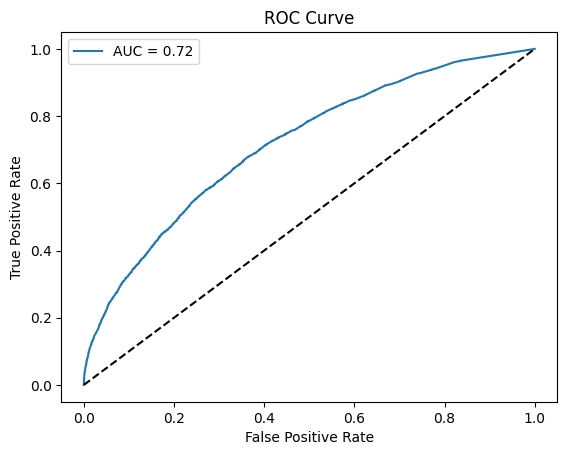

Total expected revenue loss: 913254.96

Estimated Revenue Loss by Month:
 arrival_date_month
April         82697.324082
August       248037.970710
December      25401.781600
February      10976.935854
January        7566.424718
July         177468.533803
June         110373.754681
March         28113.674095
May          104870.605118
November      10032.301455
October       43095.908250
September     64619.747657
Name: expected_loss, dtype: float64

✅ Project Complete! Cleaned data saved, model built, insights and revenue loss estimated.


In [1]:
# ============================================
# 📦 PHASE 1: DATA UNDERSTANDING & CLEANING
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

import warnings
warnings.filterwarnings("ignore")

# Load data
df = pd.read_csv("Hotel Bookings (1) (1) (1).csv")  # Update with actual filename
print("Initial shape:", df.shape)

# Drop rows with missing values in crucial fields
df.dropna(subset=['children', 'country'], inplace=True)

# Fill missing values
df['agent'] = df['agent'].fillna(0)
df['company'] = df['company'].fillna(0)
df['children'] = df['children'].fillna(0)

# Remove duplicates
df.drop_duplicates(inplace=True)

# Remove outliers
df = df[df['lead_time'] < 500]

# Save cleaned version
df.to_csv('cleaned_hotel_bookings.csv', index=False)
print("Cleaned shape:", df.shape)

# ============================================
# 🔍 PHASE 2: EXPLORATORY DATA ANALYSIS (EDA)
# ============================================

# Booking trend by month
monthly_bookings = df['arrival_date_month'].value_counts().sort_index()
plt.figure(figsize=(10,5))
sns.barplot(x=monthly_bookings.index, y=monthly_bookings.values)
plt.title('Bookings by Month')
plt.xticks(rotation=45)
plt.show()

# Cancellation rate
cancellation_rate = df['is_canceled'].value_counts(normalize=True) * 100
print("Cancellation Rate:\n", cancellation_rate)

# Lead time vs cancellation
plt.figure(figsize=(8,4))
sns.boxplot(x='is_canceled', y='lead_time', data=df)
plt.title('Lead Time vs Cancellation')
plt.show()

# Correlation heatmap
plt.figure(figsize=(14,10))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Heatmap')
plt.show()

# ============================================
# 🤖 PHASE 3: CANCELLATION PREDICTION MODEL
# ============================================

# Feature selection
features = ['lead_time', 'booking_changes', 'previous_cancellations', 'adr', 'total_of_special_requests']
X = df[features]
y = df['is_canceled']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Evaluation
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.2f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# ============================================
# 💰 PHASE 4: REVENUE LOSS ESTIMATION
# ============================================

df_model = df.copy()
df_model['cancel_prob'] = model.predict_proba(df_model[features])[:,1]
df_model['expected_loss'] = df_model['adr'] * df_model['cancel_prob']

# Filter high risk
high_risk = df_model[(df_model['cancel_prob'] > 0.8) & (df_model['adr'] > df_model['adr'].median())]
print("Total expected revenue loss: {:.2f}".format(high_risk['expected_loss'].sum()))

# Monthly loss summary
monthly_loss = high_risk.groupby('arrival_date_month')['expected_loss'].sum()
print("\nEstimated Revenue Loss by Month:\n", monthly_loss)

# ============================================
# 📊 PHASE 5: DASHBOARD + FINAL REPORT
# ============================================

print("\n✅ Project Complete! Cleaned data saved, model built, insights and revenue loss estimated.")

# Optionally, export key outputs
high_risk[['hotel', 'adr', 'cancel_prob', 'expected_loss']].to_csv("high_risk_bookings.csv", index=False)
monthly_loss.to_csv("monthly_revenue_loss.csv")
